In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [3]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + threadIdx.y * blockDim.x)

    #define _WIDTH (blockDim.x * blockDim.y)

    #define _INDEX(x,y) (x + y * _WIDTH)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec(float *grad, float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            // out need to be initialized
            out[x] += A[_INDEX(j,x)] * theta[j];
        }

        __syncthreads();
        out[x] -= b[x];
        __syncthreads();

        for (int k = 0; k < _WIDTH; k++)
        {
            grad[x] += A[_INDEX(x,k)] * out[k];
        }

        __syncthreads();
    }
    """
)

update_ker = SourceModule(
    """
    #define _X (threadIdx.x + threadIdx.y * blockDim.x)

    __global__ void update_ker(float *theta_new, float *theta, float lr, float *grad)
    {
        int x = _X;

        theta_new[x] = theta[x] - grad[x] * lr;

        __syncthreads();
    }
    """
)

multiply = ker.get_function("mat_vec")
update = update_ker.get_function("update_ker")

# Device Query

In [ ]:
device_attributes_tuples = drv.Device(0).get_attributes()

In [ ]:
device_attributes_tuples

{pycuda._driver.device_attribute.MAX_THREADS_PER_BLOCK: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_X: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Y: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Z: 64,
 pycuda._driver.device_attribute.MAX_GRID_DIM_X: 2147483647,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Y: 65535,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Z: 65535,
 pycuda._driver.device_attribute.MAX_SHARED_MEMORY_PER_BLOCK: 49152,
 pycuda._driver.device_attribute.TOTAL_CONSTANT_MEMORY: 65536,
 pycuda._driver.device_attribute.WARP_SIZE: 32,
 pycuda._driver.device_attribute.MAX_PITCH: 2147483647,
 pycuda._driver.device_attribute.MAX_REGISTERS_PER_BLOCK: 65536,
 pycuda._driver.device_attribute.CLOCK_RATE: 1590000,
 pycuda._driver.device_attribute.TEXTURE_ALIGNMENT: 512,
 pycuda._driver.device_attribute.GPU_OVERLAP: 1,
 pycuda._driver.device_attribute.MULTIPROCESSOR_COUNT: 40,
 pycuda._driver.device_attribute.KERNEL_EXEC_TIMEOUT: 0,
 pycuda._driver.device

In [ ]:
drv.Device(0).total_memory() // (1024**3)   # GB

14

# Gradient Calculation

In [ ]:
mod = SourceModule("""
__global__ void multiply_them(float *dest, float *a, float *b)
{
  const int i = threadIdx.x;
  dest[i] = a[i] * b[i];
}
""")

multiply_them = mod.get_function("multiply_them")

a = np.random.randn(400).astype(np.float32)
b = np.random.randn(400).astype(np.float32)

dest = np.zeros_like(a)
multiply_them(
        drv.Out(dest), drv.In(a), drv.In(b),
        block=(400,1,1), grid=(1,1))

print(dest-a*b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [ ]:
ker = SourceModule(
    """
    #define _X (threadIdx.x)

    #define WIDTH (blockDim.y)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec(float *out, float *a, float *b)
    {
        int x = _X;

        out[x] = a[x] * b[x];
    }
    """
)

multiply = ker.get_function("mat_vec")

In [ ]:
if __name__ == "__main__":
    # set matrix size
    N = 32

    A = np.float32(np.random.randn(N))
    b = np.float32(np.random.randn(N))
    out = np.float32(np.zeros((N)))

    multiply(drv.Out(out), drv.In(A), drv.In(b), block=(N,1,1), grid=(1,1,1))

    out_cpu = A * b
    
    print(f"Does it right?: {np.allclose(out_cpu, out)}")

Does it right?: True


In [ ]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x)
    #define _Y (threadIdx.y + blockIdx.y * blockDim.y)

    #define _WIDTH (blockDim.x * gridDim.x)
    #define _HEIGHT (blockDim.y * gridDim.y)

    #define _XM(x) ((x + _WIDTH) % _WIDTH)
    #define _YM(y) ((y + _HEIGHT) % _HEIGHT)

    #define  _INDEX(x,y) (_XM(x) + _YM(y) * _WIDTH)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec(float *grad, float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            out[x] += A[_INDEX(j,x)] * theta[j];
        }

        __syncthreads();
        out[x] -= b[x];
        __syncthreads();

        for (int k = 0; k < _HEIGHT; k++)
        {
            grad[x] += A[_INDEX(x,k)] * out[k];
        }
    }
    """
)

multiply = ker.get_function("mat_vec")

In [ ]:
if __name__ == "__main__":
    # set matrix size
    # BD: blockDim, GD: gridDim
    BD = 32
    GD = 1

    A = np.float32(np.random.randn(BD*GD,BD*GD))
    b = np.float32(np.random.randn(BD*GD))
    theta = np.float32(np.random.randn(BD*GD))
    out = np.float32(np.zeros((BD*GD)))
    grad = np.float32(np.zeros((BD*GD)))

    A_gpu = gpuarray.to_gpu(A)
    b_gpu = gpuarray.to_gpu(b)
    theta_gpu = gpuarray.to_gpu(theta)
    out_gpu = gpuarray.to_gpu(out)
    grad_gpu = gpuarray.to_gpu(grad)

    # in GPU
    multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,BD,1), grid=(GD,GD,1))
    grad_from_gpu = grad_gpu.get()
    
    # in CPU
    out_cpu = np.dot(A.T, (np.dot(A,theta) - b))

    print(f"Does it right?: {np.allclose(out_cpu, grad_from_gpu)}")
    print(f"How about 2-Norm?: {np.linalg.norm(out_cpu - grad_from_gpu)}")
    """
    t1 = time()
    for i in range(500):
        multiply(out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,BD,1), grid=(GD,GD,1))
    t2 = time()
     
    t3 = time()
    for i in range(500):
        out_cpu = np.dot(A,theta) - b
    t4 = time()

    print(f"How fast is gpu?:\nCPU: {round(t4-t3, 5)}\nGPU: {round(t2-t1, 5)}")
    """

Does it right?: True
How about 2-Norm?: 4.04166967200581e-05


# Update theta

In [ ]:
update_ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x)
    #define _Y (threadIdx.y + blockIdx.y * blockDim.y)

    __global__ void update_ker(float *theta_new, float *theta, float lr, float *grad)
    {
        int x = _X;

        theta_new[x] = theta[x] - grad[x] * lr;
    }
    """
)

update = update_ker.get_function("update_ker")

In [ ]:
if __name__ == "__main__":
    # set matrix size
    # BD: blockDim, GD: gridDim
    BD = 32
    GD = 3

    lr = np.float32(1e-4)

    A = np.float32(np.random.randn(BD*GD,BD*GD))
    b = np.float32(np.random.randn(BD*GD))
    theta = np.float32(np.random.randn(BD*GD))
    out = np.float32(np.zeros((BD*GD)))
    grad = np.float32(np.zeros((BD*GD)))

    A_gpu = gpuarray.to_gpu(A)
    b_gpu = gpuarray.to_gpu(b)
    theta_gpu = gpuarray.to_gpu(theta)
    theta_new_gpu = gpuarray.empty_like(theta_gpu)
    out_gpu = gpuarray.to_gpu(out)
    grad_gpu = gpuarray.to_gpu(grad)

    # in GPU
    multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,BD,1), grid=(GD,GD,1))
    update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD*GD,1,1), grid=(1,1,1))
    theta_gpu[:] = theta_new_gpu[:]
    result_gpu = theta_gpu.get()
    
    # in CPU
    out_cpu = np.dot(A.T, (np.dot(A,theta) - b))
    result_cpu = theta - out_cpu *lr

    """
    # in GPU
    for i in range(500):
        multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,BD,1), grid=(GD,GD,1))
        update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD*GD,1,1), grid=(1,1,1))
        theta_gpu[:] = theta_new_gpu[:]
    result_gpu = theta_gpu.get()
    
    # in CPU
    for i in range(500):
        out_cpu = np.dot(A.T, (np.dot(A,theta) - b))
        theta = theta - out_cpu *lr
    result_cpu = theta
    """

    print(f"Does it right?: {np.allclose(result_cpu, result_gpu)}")
    print(f"How about 2-Norm?: {np.linalg.norm(result_cpu - result_gpu)}")

Does it right?: False
How about 2-Norm?: nan


오버헤드 엄청 심하던거 해결....<br>
ram 만 잘 조절하면 이 친구는 안걸림...<br>
PyCUDA 만세!<br>
C 만세!

# Accuracy improvement

## $A\theta-b$

In [ ]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + threadIdx.y * blockDim.x)

    #define _WIDTH (blockDim.x * blockDim.y)

    #define _INDEX(x,y) (x + y * _WIDTH)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec(float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            // out need to be initialized
            out[x] += A[_INDEX(j,x)] * theta[j];
        }

        out[x] -= b[x];
    }
    """
)

multiply = ker.get_function("mat_vec")

In [ ]:
if __name__ == "__main__":
    # set matrix size
    # BD: blockDim, GD: gridDim
    BD_x = 32
    BD_y = 32

    A = np.float32(np.random.randn(BD_x*BD_y,BD_x*BD_y))
    b = np.float32(np.random.randn(BD_x*BD_y))
    theta = np.float32(np.random.randn(BD_x*BD_y))

    A_gpu = gpuarray.to_gpu(A.reshape(BD_x*BD_y*BD_x*BD_y))
    b_gpu = gpuarray.to_gpu(b)
    theta_gpu = gpuarray.to_gpu(theta)
    out_gpu = gpuarray.empty_like(theta_gpu)
    init_gpu = gpuarray.empty_like(theta_gpu)

    # in GPU
    multiply(out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
    result_gpu = out_gpu.get()
    out_gpu[:] = init_gpu
    
    # in CPU
    result_cpu = np.dot(A,theta) - b

    print(f"Does it right?: {np.allclose(result_cpu, result_gpu)}")
    print(f"How about 2-Norm?: {np.linalg.norm(result_cpu - result_gpu)}")

Does it right?: False
How about 2-Norm?: 0.0005948537145741284


## $\nabla f(\theta) = A^{T}(A\theta - b)$

In [ ]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + threadIdx.y * blockDim.x)

    #define _WIDTH (blockDim.x * blockDim.y)

    #define _INDEX(x,y) (x + y * _WIDTH)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec(float *grad, float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            // out need to be initialized
            out[x] += A[_INDEX(j,x)] * theta[j];
        }

        __syncthreads();
        out[x] -= b[x];
        __syncthreads();

        for (int k = 0; k < _WIDTH; k++)
        {
            grad[x] += A[_INDEX(x,k)] * out[k];
        }

        __syncthreads();
    }
    """
)

multiply = ker.get_function("mat_vec")

In [ ]:
if __name__ == "__main__":
    # set matrix size
    # BD: blockDim, GD: gridDim
    BD_x = 32
    BD_y = 32

    A = np.float32(np.random.randn(BD_x*BD_y,BD_x*BD_y))
    b = np.float32(np.random.randn(BD_x*BD_y))
    theta = np.float32(np.random.randn(BD_x*BD_y))

    A_gpu = gpuarray.to_gpu(A.reshape(BD_x*BD_y*BD_x*BD_y))
    b_gpu = gpuarray.to_gpu(b)
    theta_gpu = gpuarray.to_gpu(theta)
    out_gpu = gpuarray.empty_like(theta_gpu)
    grad_gpu = gpuarray.empty_like(theta_gpu)
    init_gpu = gpuarray.empty_like(theta_gpu)

    # in GPU
    multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
    result_gpu = grad_gpu.get()
    out_gpu[:] = init_gpu
    grad_gpu[:] = init_gpu
    
    # in CPU
    result_cpu = np.dot(A.T, np.dot(A,theta) - b)

    print(f"Does it right?: {np.allclose(result_cpu, result_gpu)}")
    print(f"How about 2-Norm?: {np.linalg.norm(result_cpu - result_gpu)}")

Does it right?: False
How about 2-Norm?: 0.031918417662382126


## $\theta = \theta - \eta \cdot \nabla f(\theta)$

In [ ]:
update_ker = SourceModule(
    """
    #define _X (threadIdx.x + threadIdx.y * blockDim.x)

    __global__ void update_ker(float *theta_new, float *theta, float lr, float *grad)
    {
        int x = _X;

        theta_new[x] = theta[x] - grad[x] * lr;

        __syncthreads();
    }
    """
)

update = update_ker.get_function("update_ker")

In [ ]:
if __name__ == "__main__":
    # set matrix size
    # BD: blockDim, GD: gridDim
    BD_x = 32
    BD_y = 32

    lr = np.float32(1e-4)

    A = np.float32(np.random.randn(BD_x*BD_y,BD_x*BD_y))
    b = np.float32(np.random.randn(BD_x*BD_y))
    theta = np.float32(np.random.randn(BD_x*BD_y))

    A_gpu = gpuarray.to_gpu(A.reshape(BD_x*BD_y*BD_x*BD_y))
    b_gpu = gpuarray.to_gpu(b)
    theta_gpu = gpuarray.to_gpu(theta)
    theta_new_gpu = gpuarray.to_gpu(theta)
    out_gpu = gpuarray.empty_like(theta_gpu)
    grad_gpu = gpuarray.empty_like(theta_gpu)
    init_gpu = gpuarray.empty_like(theta_gpu)

    # in GPU
    multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
    update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
    result_gpu = theta_new_gpu.get()
    out_gpu[:] = init_gpu
    grad_gpu[:] = init_gpu
    theta_gpu[:] = theta_new_gpu[:]
    theta_new_gpu[:] = init_gpu
    
    # in CPU
    grad_cpu = np.dot(A.T, np.dot(A,theta) - b)
    result_cpu = theta - grad_cpu * lr

    print(f"Does it right?: {np.allclose(result_cpu, result_gpu)}")
    print(f"How about 2-Norm?: {np.linalg.norm(result_cpu - result_gpu)}")

Does it right?: False
How about 2-Norm?: 3.306563712612842e-06


Success..!

# Test...

## Run time check

In [ ]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + threadIdx.y * blockDim.x)

    #define _WIDTH (blockDim.x * blockDim.y)

    #define _INDEX(x,y) (x + y * _WIDTH)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec(float *grad, float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            // out need to be initialized
            out[x] += A[_INDEX(j,x)] * theta[j];
        }

        __syncthreads();
        out[x] -= b[x];
        __syncthreads();

        for (int k = 0; k < _WIDTH; k++)
        {
            grad[x] += A[_INDEX(x,k)] * out[k];
        }

        __syncthreads();
    }
    """
)

update_ker = SourceModule(
    """
    #define _X (threadIdx.x + threadIdx.y * blockDim.x)

    __global__ void update_ker(float *theta_new, float *theta, float lr, float *grad)
    {
        int x = _X;

        theta_new[x] = theta[x] - grad[x] * lr;

        __syncthreads();
    }
    """
)

multiply = ker.get_function("mat_vec")
update = update_ker.get_function("update_ker")

In [ ]:
def stop_watch(n):
    # set matrix size
    # BD: blockDim, GD: gridDim
    BD_x = 32
    BD_y = 32

    lr = np.float32(1e-4)

    A = np.float32(np.random.randn(BD_x*BD_y,BD_x*BD_y))
    b = np.float32(np.random.randn(BD_x*BD_y))
    theta = np.float32(np.random.randn(BD_x*BD_y))

    A_gpu = gpuarray.to_gpu(A.reshape(BD_x*BD_y*BD_x*BD_y))
    b_gpu = gpuarray.to_gpu(b)
    theta_gpu = gpuarray.to_gpu(theta)
    theta_new_gpu = gpuarray.to_gpu(theta)
    out_gpu = gpuarray.empty_like(theta_gpu)
    grad_gpu = gpuarray.empty_like(theta_gpu)
    init_gpu = gpuarray.empty_like(theta_gpu)

    # in GPU
    t1 = time()
    for i in range(n):
        # initialize
        out_gpu[:] = init_gpu
        grad_gpu[:] = init_gpu
        theta_gpu[:] = theta_new_gpu[:]
        theta_new_gpu[:] = init_gpu

        # calculate
        multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
        update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
    t2 = time()

    gpu_time = t2 - t1

    # return result
    result_gpu = theta_new_gpu.get()
    
    # in CPU
    t1 = time()
    for i in range(n):
        grad_cpu = np.dot(A.T, np.dot(A,theta) - b)
        theta -= grad_cpu * lr
    t2 = time()

    cpu_time = t2 - t1
    result_cpu = theta

    error_cpu_gpu = np.linalg.norm(result_cpu - result_gpu)
    
    return error_cpu_gpu, gpu_time, cpu_time

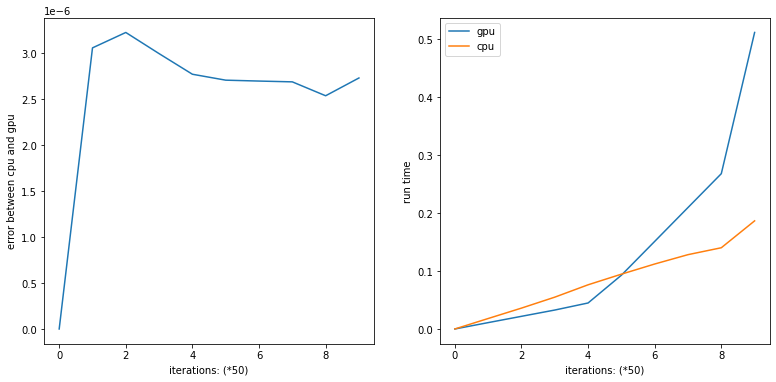

In [ ]:
N = 10

result = np.zeros((3,N))

for i in range(N-1,0,-1):
    result[:,i] = np.array(stop_watch(i * 50))

plt.figure(figsize=(13,6))

plt.subplot(121)
plt.plot(result[0,:])
plt.xlabel("iterations: (*50)")
plt.ylabel("error between cpu and gpu")

plt.subplot(122)
plt.plot(result[1,:], label="gpu")
plt.plot(result[2,:], label="cpu")
plt.xlabel("iterations: (*50)")
plt.ylabel("run time")
plt.legend()

plt.show()

## Convergence rate check

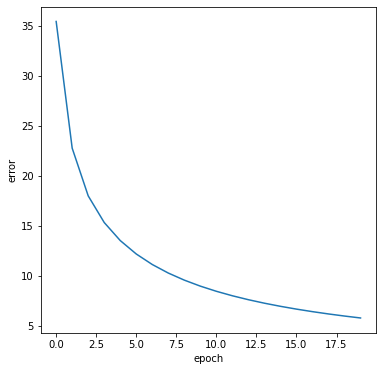

error: 5.757300853729248
run time: 4.879581689834595 seconds


In [ ]:
# set matrix size
# BD: blockDim, GD: gridDim
BD_x = 32
BD_y = 32
epoches = 10 * 2
iterations = 4 * 50
error_list = np.empty(epoches)

lr = np.float32(1e-4)

A = np.float32(np.random.randn(BD_x*BD_y,BD_x*BD_y))
b = np.float32(np.random.randn(BD_x*BD_y))
theta = np.float32(np.random.randn(BD_x*BD_y))

A_gpu = gpuarray.to_gpu(A.reshape(BD_x*BD_y*BD_x*BD_y))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
theta_new_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.empty_like(theta_gpu)
grad_gpu = gpuarray.empty_like(theta_gpu)
init_gpu = gpuarray.empty_like(theta_gpu)

t1 = time()
for epoch in range(epoches):
    for iteration in range(iterations):
        # initialize
        out_gpu[:] = init_gpu
        grad_gpu[:] = init_gpu
        theta_gpu[:] = theta_new_gpu[:]
        theta_new_gpu[:] = init_gpu

        # calculate
        multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
        update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))

    result_gpu = theta_new_gpu.get()

    error = np.linalg.norm(np.dot(A, result_gpu) - b)
    error_list[epoch] = error
t2 = time()

plt.figure(figsize=(6,6))

plt.plot(error_list)
plt.xlabel("epoch")
plt.ylabel("error")

plt.show()

print(f"error: {np.linalg.norm(np.dot(A, result_gpu) - b)}")
print(f"run time: {t2 - t1} seconds")

In [ ]:
t1 = time()
theta = np.linalg.lstsq(A,b, rcond=None)[0]
t2 = time()
print(f"error: {np.linalg.norm(np.dot(A,theta) - b)}")
print(f"run time: {t2 - t1}")

error: 0.00018605278455652297
run time: 1.3492162227630615


사실 1024 * 1024 짜리 matrix는 QR을 GPU에서 하도록 하는게 더 빠를 듯 합니다...

개선의 여지: shared memory 사용.. 요거는 overhead가 무섭습니다...

## Hyper parameter tuning

In [54]:
class HyperParameaterTuning:
    def __init__(self, A, b, theta, N, lr_min=0.5e-4, lr_max=1.5e-4):
        # parameter
        self.N = N
        self.lr_dict = {}
        lr = np.linspace(lr_min, lr_max, self.N)
        for i in range(N):
            self.lr_dict[i] = np.float32(round(lr[i], 6))

        # set matrix size
        # BD: blockDim
        self.BD_x = 32
        self.BD_y = 32
        self.epoches = 10
        self.iterations = 4 * 50
        self.error_list = np.empty((epoches,self.N))
        self.size = self.BD_x * self.BD_y

        # data
        self.A = A
        self.b = b
        self.theta = theta

    def initialize(self):
        self.A_gpu = gpuarray.to_gpu(self.A.reshape(self.size*self.size))
        self.b_gpu = gpuarray.to_gpu(self.b)
        self.theta_gpu = gpuarray.to_gpu(self.theta)
        self.theta_new_gpu = gpuarray.to_gpu(self.theta)
        self.out_gpu = gpuarray.empty_like(self.theta_gpu)
        self.grad_gpu = gpuarray.empty_like(self.theta_gpu)
        self.init_gpu = gpuarray.empty_like(self.theta_gpu)

    def tune(self):
        for key, lr in self.lr_dict.items():
            # data initialize
            self.initialize()

            # learning
            for epoch in range(self.epoches):
                for iteration in range(self.iterations):
                    # initialize
                    self.out_gpu[:] = self.init_gpu
                    self.grad_gpu[:] = self.init_gpu
                    self.theta_gpu[:] = self.theta_new_gpu[:]
                    self.theta_new_gpu[:] = self.init_gpu

                    # calculate
                    multiply(self.grad_gpu, self.out_gpu, self.A_gpu, self.b_gpu, self.theta_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
                    update(self.theta_new_gpu, self.theta_gpu, lr, self.grad_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))

                result_gpu = self.theta_new_gpu.get()

                error = np.linalg.norm(np.dot(self.A, result_gpu) - self.b)
                self.error_list[epoch,key] = error

        self.visualize()

    def visualize(self):
        if N % 2 == 0:
            fig_x = int(N/2)
            fig_y = int(N//2)
        
        else:
            print("N = 2 * k")

        plt.figure(figsize=(4*fig_x,4*fig_y))
        for i in range(N):
            lr = round(self.lr_dict[i], 5)
            plt.subplot(fig_y,fig_x,i+1)
            plt.plot(self.error_list[:,i])
            plt.title(f"lr = {lr}")

        plt.show()

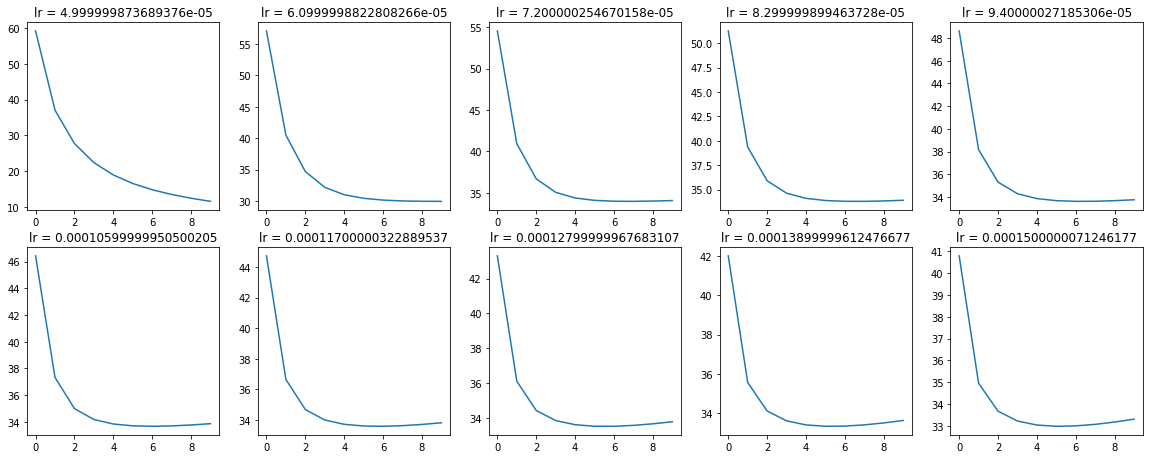

In [55]:
BD_x = 32
BD_y = 32

N = 10

A = np.float32(np.random.randn(BD_x*BD_y,BD_x*BD_y))
b = np.float32(np.random.randn(BD_x*BD_y))
theta = np.float32(np.random.randn(BD_x*BD_y))

for_tuning = HyperParameaterTuning(A, b, theta, N)
for_tuning.tune()

# Bigger data

In [40]:
calculate_ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x * blockDim.y)

    #define _WIDTH (blockDim.x)

    #define _INDEX1(x,y) (x + y * _WIDTH)
    #define _INDEX2(x,y) (x + y * gridDim.x)

    // A: matrix, b: vector, out: vector
    __global__ void mat_vec_ker(float *out, float *A, float *b, float *theta)
    {
        int x = _X;

        for (int j = 0; j < _WIDTH; j++)
        {
            // out need to be initialized
            out[x] += A[_INDEX1(j,x)] * theta[j];
        }

        __syncthreads();
        out[x] -= b[x];
        __syncthreads();
    }

    __global__ void gradient_ker(float *grad, float *out, float *A)
    {
        int x = _X;
        
        for (int k = 0; k < _WIDTH; k++)
        {
            grad[_INDEX2(x,blockIdx.x)] += A[_INDEX1(x,k)] * out[k];
        }

        __syncthreads();

        for (int k = 0; k < gridDim.x; k++)
        {
            grad[_INDEX2(x,gridDim.x)] += grad[_INDEX2(x,k)];
        }
    }
    """
)

update_ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x * blockDim.y)

    __global__ void update_ker(float *theta_new, float *theta, float lr, float *grad)
    {
        int x = _X;

        theta_new[x] = theta[x] - grad[x] * lr;

        __syncthreads();
    }
    """
)

multiply = calculate_ker.get_function("mat_vec_ker")
gradient = calculate_ker.get_function("gradient_ker")
update = update_ker.get_function("update_ker")

In [45]:
# set matrix size
# BD: blockDim, GD: gridDim   
BD = 32 * 32
GD_x = 2

lr = np.float32(1e-4)

A = np.float32(np.random.randn(BD*GD_x,BD))
b = np.float32(np.random.randn(BD*GD_x))
theta = np.float32(np.random.randn(BD))
out_cpu = np.float32(np.zeros((BD,GD_x+1)))

A_gpu = gpuarray.to_gpu(A.reshape(BD*BD*GD_x))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
theta_new_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.empty_like(b_gpu)
grad_gpu = gpuarray.to_gpu(out_cpu)
init_gpu1 = gpuarray.empty_like(theta_gpu)
init_gpu2 = gpuarray.empty_like(b_gpu)
init_gpu3 = gpuarray.empty_like((grad_gpu))

# initialize
out_gpu[:] = init_gpu2
grad_gpu[:] = init_gpu3
theta_gpu[:] = theta_new_gpu[:]
theta_new_gpu[:] = init_gpu1

multiply(out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD,1,1), grid=(GD_x,1,1))
# gradient(grad_gpu, out_gpu, A_gpu, block=(BD,1,1), grid=(GD_x,1,1))
# update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD,1,1), grid=(1,1,1))

result_gpu = out_gpu.get()
# result_gpu = grad_gpu.get()
# result_gpu = theta_new_gpu.get()

"""
# in GPU
t1 = time()
for i in range(200):
    # initialize
    out_gpu[:] = init_gpu
    grad_gpu[:] = init_gpu
    theta_gpu[:] = theta_new_gpu[:]
    theta_new_gpu[:] = init_gpu

    # calculate
    multiply(grad_gpu, out_gpu, A_gpu, b_gpu, theta_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
    update(theta_new_gpu, theta_gpu, lr, grad_gpu, block=(BD_x,BD_y,1), grid=(1,1,1))
t2 = time()
"""

# in CPU
result_cpu = np.dot(A, theta) - b
# result_cpu = np.dot(A.T, (np.dot(A,theta) - b))
# result_cpu = theta - np.dot(A.T, (np.dot(A, theta) - b)) * lr

print(f"Does it right?: {np.allclose(result_cpu, result_gpu, atol=1e-4)}")
print(f"How about 2-Norm?: {np.linalg.norm(result_cpu - result_gpu)}")

Does it right?: True
How about 2-Norm?: 0.0009199508931487799


In [38]:
result_cpu

array([ 10.2600565, -28.39796  ,  20.28945  , ...,  15.060919 ,
        19.452477 ,   4.220759 ], dtype=float32)

In [39]:
result_gpu

array([ 10.260042, -28.397982,  20.289444, ...,  15.060913,  19.452473,
         4.220756], dtype=float32)